# Sentiment Analysis

# PART 1

## Installs, Imports and Paths

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!pip install -U scikit_learn
!pip install -U nltk
!pip install -U datasets
!pip install --upgrade tensorflow
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 21.6 MB/s eta 0:00:00
  Attempting uninstall: scikit_learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.1 MB/s 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import tensorflow as tf
import os
import scipy
import keras
import random
from datasets import load_dataset
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from nltk import sent_tokenize, word_tokenize, pos_tag
from pandas.core.missing import find_valid_index
from sklearn.model_selection import learning_curve, GridSearchCV
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from google.colab import files

stemmer = WordNetLemmatizer()
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
if not os.path.exists('./Sentiment-Analysis'):
  os.makedirs('./Sentiment-Analysis')
os.chdir('./Sentiment-Analysis')

## Data Preprocessing

### Dataset Loading

In [ ]:
def remove(text, polarity, n):
    for _ in range(int(len(text)*n)):
        number = random.randrange(0,len(text))
        text.pop(number)
        polarity.pop(number)
    return

#importing the dataset
tweets = load_dataset("tweet_eval",'sentiment')

#create train/dev/test sets 
train = tweets['train']
dev = tweets['validation']
test = tweets['test']

x_train = train['text']
x_val = dev['text'] 
x_test = test['text']

y_train = train['label'] 
y_val = dev['label']
y_test = test['label']

#removing big parts because of too many data
#remove(x_train, y_train, 0.9)
#remove(x_val, y_val, 0.9)
#remove(x_test, y_test, 0.9)

print("Training Data Size: ", len(x_train))
print("Evaluation Data Size: ", len(x_val))
print("Test Data Size: ", len(x_test))


Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Training Data Size:  45615
Evaluation Data Size:  2000
Test Data Size:  12284


### Heuristic for text-classification

In [ ]:
total_size = []
for sent in x_train:
  internal_c = 0
  for word in sent:
    internal_c += 1
  total_size.append(internal_c)

sum = 0
for i in range(len(total_size)):
  sum += total_size[i]

mean = sum/len(total_size)

print(len(x_train))
print(mean)
print(len(x_train)/mean)

45615
106.93285103584347
426.57611349677785


### Emoji Extraction (obsolete)

In [ ]:
#def convert_emojis_to_word(text):
#    for emot in Emoji_Dict:
#        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",", "-").replace(":", "-").split()), text)
#        text = text.replace("-", " ")
#    return text


#with open('/content/Emoji_Dict.p', 'rb') as fp:
#    Emoji_Dict = pickle.load(fp)
#Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}


### Data Cleaning Custom (faster)

In [ ]:
def preProcess(x):
  document = []
  counter1 = 0
  for row in x:
      document.append(x[counter1])
      counter1 += 1


  for i in range(len(document)):
      # Extract text from Emojis and Emoticons
      # document[counter] = convert_emojis_to_word(i)

      # Remove non-word (special) characters such as punctuation, numbers etc
      document[i] = re.sub(r'\W', ' ', document[i])

      # Remove all single characters
      document[i] = re.sub(r'\s+[a-zA-Z]\s+', ' ', document[i])

      # Substitute multiple spaces with single space
      document[i] = re.sub(r'\s+', ' ', document[i], flags=re.I)

      # Convert to Lowercase
      document[i] = document[i].lower()

      # Split the document based on whitespaces (--> List of words)
      document[i] = document[i].split()

      # Lemmatization
      document[i] = [stemmer.lemmatize(word) for word in document[i]]

      # Reconstruct the document by joining the words on each whitespace
      document[i] = ' '.join(document[i])
      x[i] = document[i]

  return x


x_train_tokenized = preProcess(x_train)
x_val_tokenized = preProcess(x_val)
x_test_tokenized = preProcess(x_test)

### Data Cleaning Spacy (works a bit better)

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer') 

def tokenize_samples(samples):
  
  tokenized_samples = []
  for i in range(len(samples)):
    doc = nlp(samples[i])  # Tokenize the sample into sentences
    tokens = []
    for sent in doc.sents:
      for tok in sent:  # Iterate through the words of the sentence
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
          continue
        if tok.text.strip():  
          tokens.append(tok.text.replace('"',"'").strip())
    tokenized_samples.append(tokens)

  return tokenized_samples

X_train_tokenized = tokenize_samples(x_train)
X_val_tokenized = tokenize_samples(x_val)
X_test_tokenized = tokenize_samples(x_test)

/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


### TF-IDF Feature Extraction

In [ ]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range = (1, 3),
    max_features = 10000,
    min_df = 0.0001,
    max_df = 0.25,
    # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
    sublinear_tf = True,
    stop_words = stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - test)

# Spacy
x_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
x_val_tfidf = vectorizer.transform([" ".join(x) for x in X_val_tokenized])
x_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

# Custom
#x_train_tfidf = vectorizer.fit_transform(x_train_tokenized)
#x_val_tfidf = vectorizer.transform(x_val_tokenized)
#x_test_tfidf = vectorizer.transform(x_test_tokenized)

print('Shape of training data: {}'.format(x_train_tfidf.shape))
print('Shape of evaluation data: {}\n'.format(x_val_tfidf.shape))
print('Shape of test data: {}\n'.format(x_test_tfidf.shape))

print(x_val_tfidf[0, :])  # Sparce matrix --> Saves only the cells which are not zero

Shape of training data: (45615, 10000)
Shape of evaluation data: (2000, 10000)

Shape of test data: (12284, 10000)

  (0, 8771)	0.34681042615895413
  (0, 7821)	0.28970430393967495
  (0, 5814)	0.196184062957143
  (0, 4894)	0.32607629660635
  (0, 2281)	0.2872329701779469
  (0, 2275)	0.4361992771936199
  (0, 2274)	0.3174960235572627
  (0, 2273)	0.29709933609597977
  (0, 2025)	0.33299647352625855
  (0, 729)	0.279730274324458


## **Dummy Classifier**

In [ ]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(x_train_tfidf, y_train)

# Evaluate
dummy_predictions_train = baseline.predict(x_train_tfidf)
dummy_score = accuracy_score(y_train, dummy_predictions_train)
print("Train accuracy: {:.2f}%".format(dummy_score*100))

dummy_predictions_val = baseline.predict(x_val_tfidf)
dummy_score = accuracy_score(y_val, dummy_predictions_val)
print("Evaluation accuracy: {:.2f}% \n".format(dummy_score*100))

dummy_predictions_test = baseline.predict(x_test_tfidf)
dummy_score = accuracy_score(y_test, dummy_predictions_test)
print("Test accuracy: {:.2f}% \n".format(dummy_score*100))

Train accuracy: 45.32%
Evaluation accuracy: 43.45% 

Test accuracy: 48.33% 



##**Logistic Regression**

In [ ]:
# Train
# Solver -- Algorithm to use in the optimization problem.
lgr = LogisticRegression(multi_class='multinomial', solver='lbfgs', C= 0.9, max_iter = 50)
lgr.fit(x_train_tfidf, y_train)

# Evaluate
lgr_predictions_train = lgr.predict(x_train_tfidf)
lgr_score = f1_score(y_train, lgr_predictions_train, average='macro')
print("Train f1-score: {:.2f}% \n".format(lgr_score*100))

lgr_predictions_val = lgr.predict(x_val_tfidf)
lgr_score = f1_score(y_val, lgr_predictions_val, average='macro')
print("Evaluation f1-score: {:.2f}% \n".format(lgr_score*100))

lgr_predictions_test = lgr.predict(x_test_tfidf)
lgr_score = f1_score(y_test, lgr_predictions_test, average='macro')
print("Test f1-score: {:.2f}% \n".format(lgr_score*100))

Train f1-score: 68.40% 

Evaluation f1-score: 63.21% 

Test f1-score: 55.28% 



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##**KNN**

In [ ]:
# Train
knn = KNeighborsClassifier(n_neighbors=11, leaf_size = 1, p = 2)
knn.fit(x_train_tfidf, y_train)

# Evaluate
knn_predictions_train = knn.predict(x_train_tfidf)
knn_score = f1_score(y_train, knn_predictions_train, average = 'macro')
print("Train f1-score: {:.2f}% \n".format(knn_score*100))

knn_predictions_val = knn.predict(x_val_tfidf)
knn_score = f1_score(y_val, knn_predictions_val, average = 'macro')
print("Evaluation f1-score: {:.2f}% \n".format(knn_score*100))

knn_predictions_test = knn.predict(x_test_tfidf)
knn_score = f1_score(y_test, knn_predictions_test, average = 'macro')
print("Test f1-score: {:.2f}% \n".format(knn_score*100))

Train f1-score: 50.82% 

Evaluation f1-score: 44.15% 

Test f1-score: 40.35% 



## Learning Curves

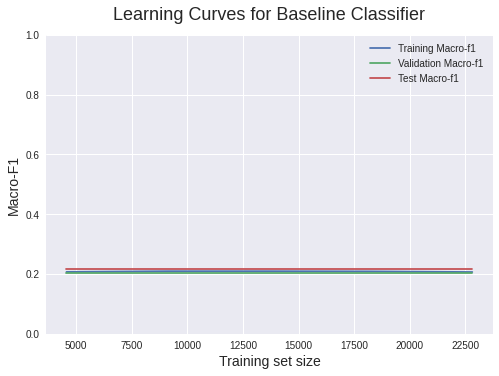

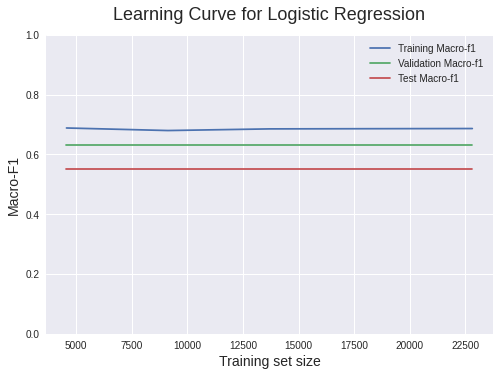

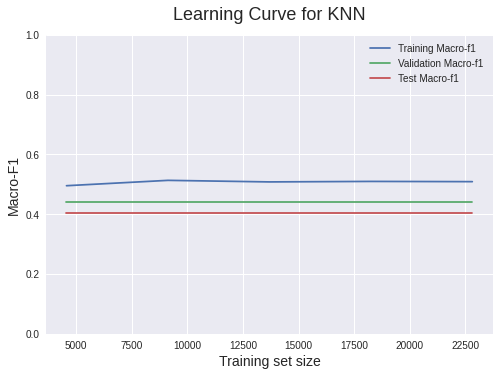

In [ ]:
def handleTrainData(x, y, i):
  # We fold the training set manually
  init_size = int(x.shape[0]) # size of the full dataset
  final_size = int(x.shape[0]*(i+1)/10) # size of the data used in this iteration
  peak_number = init_size - final_size - 1 # if the generator picks a number bigger than this then we might get an error due to indexing
  start_index = int(random.randint(0, peak_number)) # the index from which we will start receiving data
  final_index = int(start_index + final_size) # the index that we will stop
  updated_x_train_tfidf = x[start_index:final_index] # transfer the data used in this iteration to another list
  updated_y_train = y[start_index:final_index]

  return updated_x_train_tfidf, updated_y_train, final_size


def drawCurves(x_train, y_train1, x_val, y_val1, x_test, y_test1, k, classifier, title):
  m_train_f1_score = []
  m_val_f1_score = []
  m_test_f1_score = []
  train_sizes = []

  for i in range(k):
    new_x_train, new_y_train, this_size = handleTrainData(x_train, y_train1, i)
    train_sizes.insert(i, this_size)
    m_train_f1_score.insert(i, f1_score(new_y_train, classifier.predict(new_x_train), average='macro'))
    m_val_f1_score.insert(i, f1_score(y_val1, classifier.predict(x_val), average='macro'))
    m_test_f1_score.insert(i, f1_score(y_test1, classifier.predict(x_test), average='macro'))

  plt.style.use('seaborn')
  plt.figure()
  plt.plot(train_sizes, m_train_f1_score, label = 'Training Macro-f1')
  plt.plot(train_sizes, m_val_f1_score, label = 'Validation Macro-f1')
  plt.plot(train_sizes, m_test_f1_score, label = 'Test Macro-f1')
  plt.ylabel('Macro-F1', fontsize = 14)
  plt.xlabel('Training set size', fontsize = 14)
  plt.title(title, fontsize = 18, y = 1.03)
  plt.legend()
  plt.ylim(0,1)

  return train_sizes, m_train_f1_score, m_val_f1_score, m_test_f1_score


drawCurves(x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test, 5, baseline, 'Learning Curves for Baseline Classifier')
drawCurves(x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test, 5, lgr, 'Learning Curve for Logistic Regression')
with tf.device('/device:GPU:0'):
  drawCurves(x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test, 5, knn, 'Learning Curve for KNN')

##Precision, Recall, AUC, ROC-AUC

In [ ]:
def calculateResults(x, y, classifier):
  # calculate precision, recall and f1
  train_precision_score = precision_score(y, classifier.predict(x), average=None)
  train_recall_score = recall_score(y, classifier.predict(x), average=None)
  train_f1_score = f1_score(y, classifier.predict(x), average=None)

  # macro precision, recall, f1 and auc
  m_train_precision_score = precision_score(y, classifier.predict(x), average='macro')

  m_train_recall_score = recall_score(y, classifier.predict(x), average='macro')

  m_train_f1_score = f1_score(y, classifier.predict(x), average='macro')
  
  m_train_roc_auc_score = roc_auc_score(y, classifier.predict_proba(x), multi_class='ovr', average='macro')

  # auc calculation is a bit more messy

  classes = classifier.classes_ # get the classes of the model
  train_roc_auc_score = {}
  for i in range(len(classes)):
      c = classes[i]
    
      # Prepares an auxiliar dataframe to help with the plots
      df_x = pd.DataFrame (x, columns = ['text']) # convert list to a dataframe
      y_proba = classifier.predict_proba(x) # calculate the probabilities
      df_aux = df_x.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)
    
      # Calculates the ROC AUC OvR
      train_roc_auc_score[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

  # Create and print the table

  table = [['    ', 'Precision', 'Recall', 'F1', 'AUC', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-AUC'], 
           ['Positive', round(train_precision_score[0], 3), round(train_recall_score[0], 3), round(train_f1_score[0], 3), round(train_roc_auc_score[0], 3), '-', '-', '-', '-'],
           ['Neutral', round(train_precision_score[1], 3), round(train_recall_score[1], 3), round(train_f1_score[1], 3), round(train_roc_auc_score[1], 3), '-', '-', '-', '-'],
           ['Negative', round(train_precision_score[2], 3), round(train_recall_score[2], 3), round(train_f1_score[2], 3), round(train_roc_auc_score[2], 3), '-', '-', '-', '-'],
           ['Total', '-', '-','-','-', round(m_train_precision_score, 3), round(m_train_recall_score, 3), round(m_train_f1_score, 3), round(m_train_roc_auc_score, 3)]]

  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
  return table

In [ ]:
print("Dummy Classifier ------------------------------------------------------------------------------------- \n")

print("The training results: \n")
calculateResults(x_train_tfidf, y_train, baseline)

print("The evaluation results: \n")
calculateResults(x_val_tfidf, y_val, baseline)

print("The test results: \n")
calculateResults(x_test_tfidf, y_test, baseline)

print("Logistic Regression  ------------------------------------------------------------------------------------- \n")

print("The training results: \n")
train_lgr = calculateResults(x_train_tfidf, y_train, lgr)

print("The evaluation results: \n")
val_lgr = calculateResults(x_val_tfidf, y_val, lgr)

print("The test results: \n")
test_lgr = calculateResults(x_test_tfidf, y_test, lgr)

with tf.device('/device:GPU:0'):
  print("KNN  ----------------------------------------------------------------------------------------------------- \n")

  print("The training results: \n")
  train_knn = calculateResults(x_train_tfidf, y_train, knn)

  print("The evaluation results: \n")
  val_knn = calculateResults(x_val_tfidf, y_val, knn)

  print("The test results: \n")
  test_knn = calculateResults(x_test_tfidf, y_test, knn)

Dummy Classifier ------------------------------------------------------------------------------------- 

The training results: 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒══════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│          │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞══════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ Positive │ 0.0         │ 0.0      │ 0.0   │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Neutral  │ 0.453       │ 1.0      │ 0.624 │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Negative │ 0.0         │ 0.0      │ 0.0   │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒══════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│          │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞══════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ Positive │ 0.0         │ 0.0      │ 0.0   │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Neutral  │ 0.434       │ 1.0      │ 0.606 │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Negative │ 0.0         │ 0.0      │ 0.0   │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒══════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│          │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞══════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ Positive │ 0.0         │ 0.0      │ 0.0   │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Neutral  │ 0.483       │ 1.0      │ 0.652 │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Negative │ 0.0         │ 0.0      │ 0.0   │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───

##Hyper parameter tuning via Grid Search

In [ ]:
pipeline1 = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression())])

pipeline2 = Pipeline([
    ('knn', KNeighborsClassifier()),])

grid_params1 = {
  'tfidf_vectorizer__min_df': np.linspace(0.0001, 0.001, 10),
  'tfidf_vectorizer__max_df': np.linspace(0.2, 0.7, 10),
  'tfidf_vectorizer__ngram_range': [(1,1),(1,2),(1,3)],  
  'tfidf_vectorizer__sublinear_tf': [True,False],
  'lr__solver': ['lbfgs'],
  'lr__C': np.linspace(0.1, 1, 10),
  'lr__max_iter': [50, 100, 200],
}

grid_params2 = {
  'knn__n_neighbors': list(range(1,30)),
  'knn__leaf_size': list(range(1,50)),
}


gs = GridSearchCV(pipeline1, grid_params1, scoring='f1_macro', cv=3, n_jobs=-1)
gs = gs.fit(x_val, y_val)
logistic_score = gs.best_score_
logistic_params = gs.best_params_
gs2 = GridSearchCV(pipeline2, grid_params2, scoring='f1_macro', cv=3, n_jobs=-1)
gs2 = gs2.fit(x_val_tfidf, y_val) 
knn_score = gs2.best_score_
knn_params = gs2.best_params_

print("Finished Grid Search \n")



print("Best Score of Logistic Regression: ", logistic_score)
print("Best Parameters of Logistic Regression:  \n", logistic_params)

print("Best Score of KNN: ", knn_score)
print("Best Parameters of KNN:  \n", knn_params)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Finished Grid Search 

Best Score of Logistic Regression:  0.4125612613557708
Best Parameters of Logistic Regression:  
 {'lr__C': 0.9, 'lr__max_iter': 50, 'lr__solver': 'lbfgs', 'tfidf_vectorizer__max_df': 0.25555555555555554, 'tfidf_vectorizer__min_df': 0.0007999999999999999, 'tfidf_vectorizer__ngram_range': (1, 1), 'tfidf_vectorizer__sublinear_tf': True}
Best Score of KNN:  0.44558763515661354
Best Parameters of KNN:  
 {'knn__leaf_size': 1, 'knn__n_neighbors': 4}
